In [1]:
import pandas as pd
import geopandas as gp
from plotnine import (
    ggplot,
    aes,
    geom_map,
    geom_text,
    labs,
    scale_fill_brewer,
    scale_x_continuous,
    scale_y_continuous,
    scale_size_continuous,
    coord_cartesian,
    element_rect,
    theme_void,
    theme
)


### The Political Territories of Westeros

*Layering different features on a Map*

Read data and select features in Westeros only.

In [2]:
continents = gp.read_file('data/lands-of-ice-and-fire/continents.shp')
islands = gp.read_file('data/lands-of-ice-and-fire/islands.shp')
lakes = gp.read_file('data/lands-of-ice-and-fire/lakes.shp')
rivers = gp.read_file('data/lands-of-ice-and-fire/rivers.shp')
political = gp.read_file('data/lands-of-ice-and-fire/political.shp')
wall = gp.read_file('data/lands-of-ice-and-fire/wall.shp')
roads = gp.read_file('data/lands-of-ice-and-fire/roads.shp')
locations = gp.read_file('data/lands-of-ice-and-fire/locations.shp')

westeros = continents.query('name=="Westeros"')
islands = islands.query('continent=="Westeros" and name!="Summer Islands"')
lakes = lakes.query('continent=="Westeros"')
rivers = rivers.query('continent=="Westeros"')
roads = roads.query('continent=="Westeros"')

wg = westeros.geometry[0]
bool_idx = [wg.contains(g) for g in locations.geometry]
westeros_locations = locations[bool_idx]
cities = westeros_locations[westeros_locations['type'] == 'City'].copy()

Create map by placing the features in layers in an order that limits obstraction.

The `GeoDataFrame.geometry.centroid` property has the center coordinates of polygons,
we use these to place the labels of the political regions.

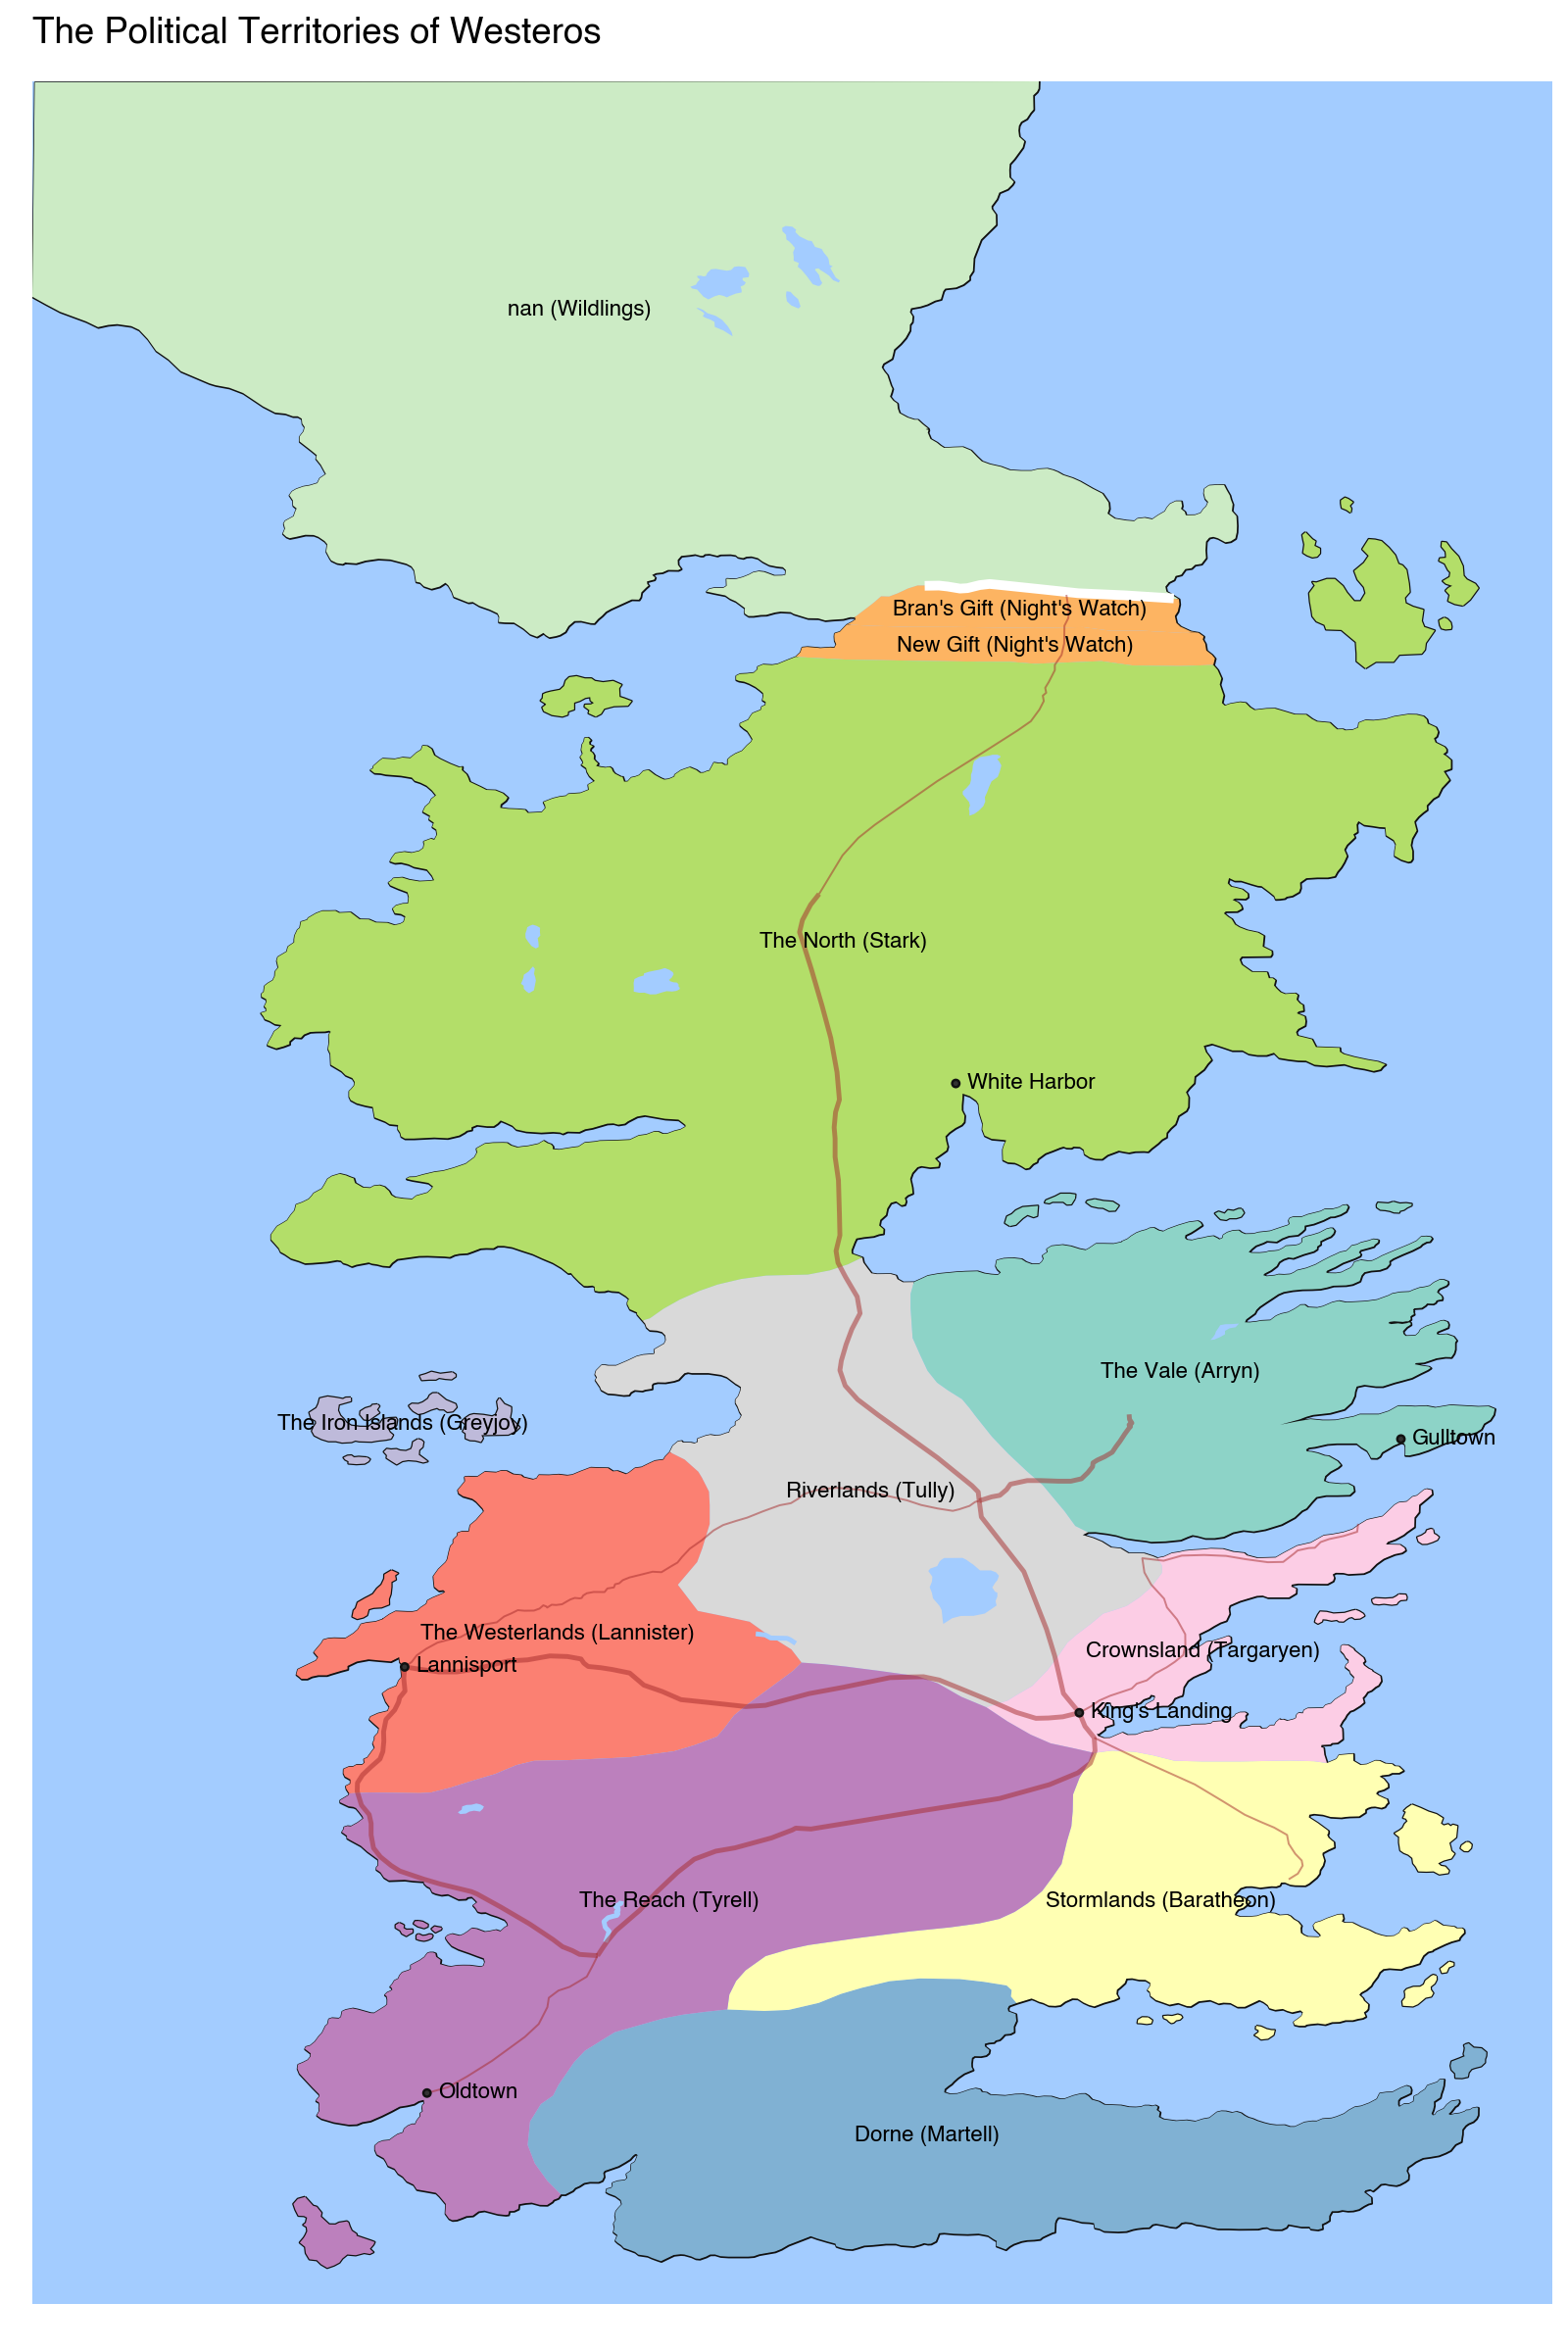

<Figure Size: (800 x 1200)>

In [3]:
# colors
water_color = '#a3ccff'
wall_color = 'white'
road_color = 'brown'

# Create label text by merging the territory name and
# the claimant to the territory
def fmt_labels(names, claimants):
    labels = []
    for name, claimant in zip(names, claimants):
        if name:
            labels.append('{} ({})'.format(name, claimant))
        else:
            labels.append('({})'.format(claimant))
    return labels


def calculate_center(df):
    """
    Calculate the centre of a geometry
    
    This method first converts to a planar crs, gets the centroid
    then converts back to the original crs. This gives a more
    accurate
    """
    original_crs = df.crs
    planar_crs = 'EPSG:3857'
    return df['geometry'].to_crs(planar_crs).centroid.to_crs(original_crs)


political['center'] = calculate_center(political)
cities['center'] = calculate_center(cities)

# Gallery Plot

(ggplot()
 + geom_map(westeros, fill=None)
 + geom_map(islands, fill=None)
 + geom_map(political, aes(fill='ClaimedBy'), color=None, show_legend=False)
 + geom_map(wall, color=wall_color, size=2)
 + geom_map(lakes, fill=water_color, color=None)
 + geom_map(rivers, aes(size='size'), color=water_color, show_legend=False)
 + geom_map(roads, aes(size='size'), color=road_color, alpha=0.5, show_legend=False)
 + geom_map(cities, size=1)
 + geom_text(
     political,
     aes('center.x', 'center.y', label='fmt_labels(name, ClaimedBy)'),
     size=8,
     fontweight='bold'
 )
 + geom_text(
     cities,
     aes('center.x', 'center.y', label='name'),
     size=8,
     ha='left',
     nudge_x=.20
 )
 + labs(title="The Political Territories of Westeros")
 + scale_fill_brewer(type='qual', palette=8)
 + scale_x_continuous(expand=(0, 0, 0, 1))
 + scale_y_continuous(expand=(0, 1, 0, 0))
 + scale_size_continuous(range=(0.4, 1))
 + coord_cartesian()
 + theme_void()
 + theme(figure_size=(8, 12), panel_background=element_rect(fill=water_color))
)

**Credit**: [cadaei](https://www.cartographersguild.com/member.php?u=95244) of the [cartographersguild](https://www.cartographersguild.com/) website forum.